In [50]:
import matplotlib.pyplot as plt
import os
import shutil
import random
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [83]:
# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

# Common path to dataset
path += '/COVID-19_Radiography_Dataset'

In [84]:
# Specific directories
covid_imgs_directory = path + "/COVID/images"
lung_opacity_imgs_directory = path + "/Lung_Opacity/images"
viral_pneummonia_imgs_directory = path + "/Viral Pneumonia/images"
normal_imgs_directory = path + "/Normal/images"

In [85]:
# Dividir imágenes en entrenamiento y validación
split_ratio = 0.8  # 80% para entrenamiento, 20% para validación

# Rutas de las clases
class_dirs = {
    "COVID": covid_imgs_directory,
    "Lung_Opacity": lung_opacity_imgs_directory,
    "Viral_Pneumonia": viral_pneummonia_imgs_directory,
    "Normal": normal_imgs_directory,
}

# Directorios de destino
base_train_dir = os.path.join(path, "training")
base_val_dir = os.path.join(path, "validation")

# Crear directorios
for class_name in class_dirs.keys():
    os.makedirs(os.path.join(base_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(base_val_dir, class_name), exist_ok=True)

# Calcular el número mínimo de imágenes en cualquier clase
min_images = min(len(os.listdir(img_dir)) for img_dir in class_dirs.values())

# Submuestrear cada clase
for class_name, img_dir in class_dirs.items():
    images = os.listdir(img_dir)
    random.shuffle(images)
    sampled_images = images[:min_images]  # Submuestrear

    # Mover imágenes submuestreadas a las carpetas de entrenamiento y validación
    train_count = int(len(sampled_images) * split_ratio)
    train_imgs = sampled_images[:train_count]
    val_imgs = sampled_images[train_count:]

    for img in train_imgs:
        shutil.move(os.path.join(img_dir, img), os.path.join(base_train_dir, class_name, img))
    for img in val_imgs:
        shutil.move(os.path.join(img_dir, img), os.path.join(base_val_dir, class_name, img))


for class_name, img_dir in class_dirs.items():
    images = os.listdir(img_dir)
    random.shuffle(images)

    train_count = int(len(images) * split_ratio)
    train_imgs = images[:train_count]
    val_imgs = images[train_count:]

    # Mover imágenes a las carpetas correspondientes
    for img in train_imgs:
        shutil.move(os.path.join(img_dir, img), os.path.join(base_train_dir, class_name, img))
    for img in val_imgs:
        shutil.move(os.path.join(img_dir, img), os.path.join(base_val_dir, class_name, img))


In [86]:
def display_images(title, directory):
    # Listar los archivos en el directorio
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleccionar las primeras 9 imágenes o menos si no hay suficientes
    num_images = min(9, len(image_files))
    selected_images = image_files[:num_images]

    # Mostrar imágenes
    plt.figure(figsize=(15, 15))
    plt.title(title)

    for i, img_path in enumerate(selected_images):
        img = plt.imread(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

In [87]:
# Directorios organizados
covid_imgs = os.path.join(base_train_dir, 'COVID')
lung_opacity_imgs = os.path.join(base_train_dir, 'Lung_Opacity')
viral_pneummonia_imgs = os.path.join(base_train_dir, 'Viral_Pneumonia')
normal_imgs = os.path.join(base_train_dir, 'Normal')

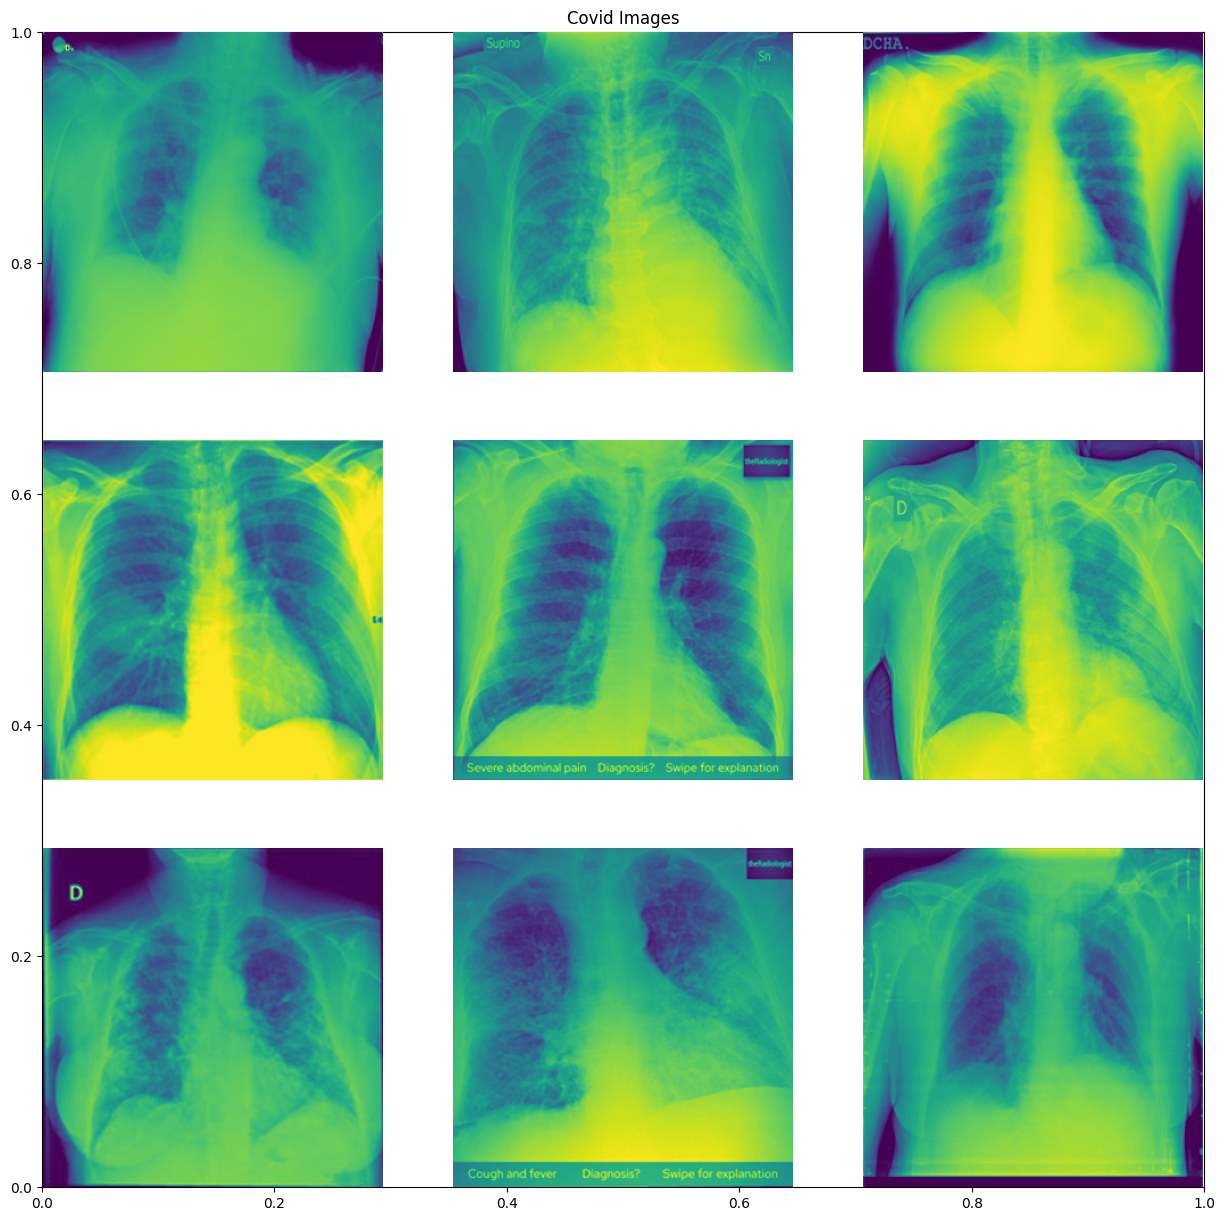

In [88]:
display_images('Covid Images', covid_imgs)

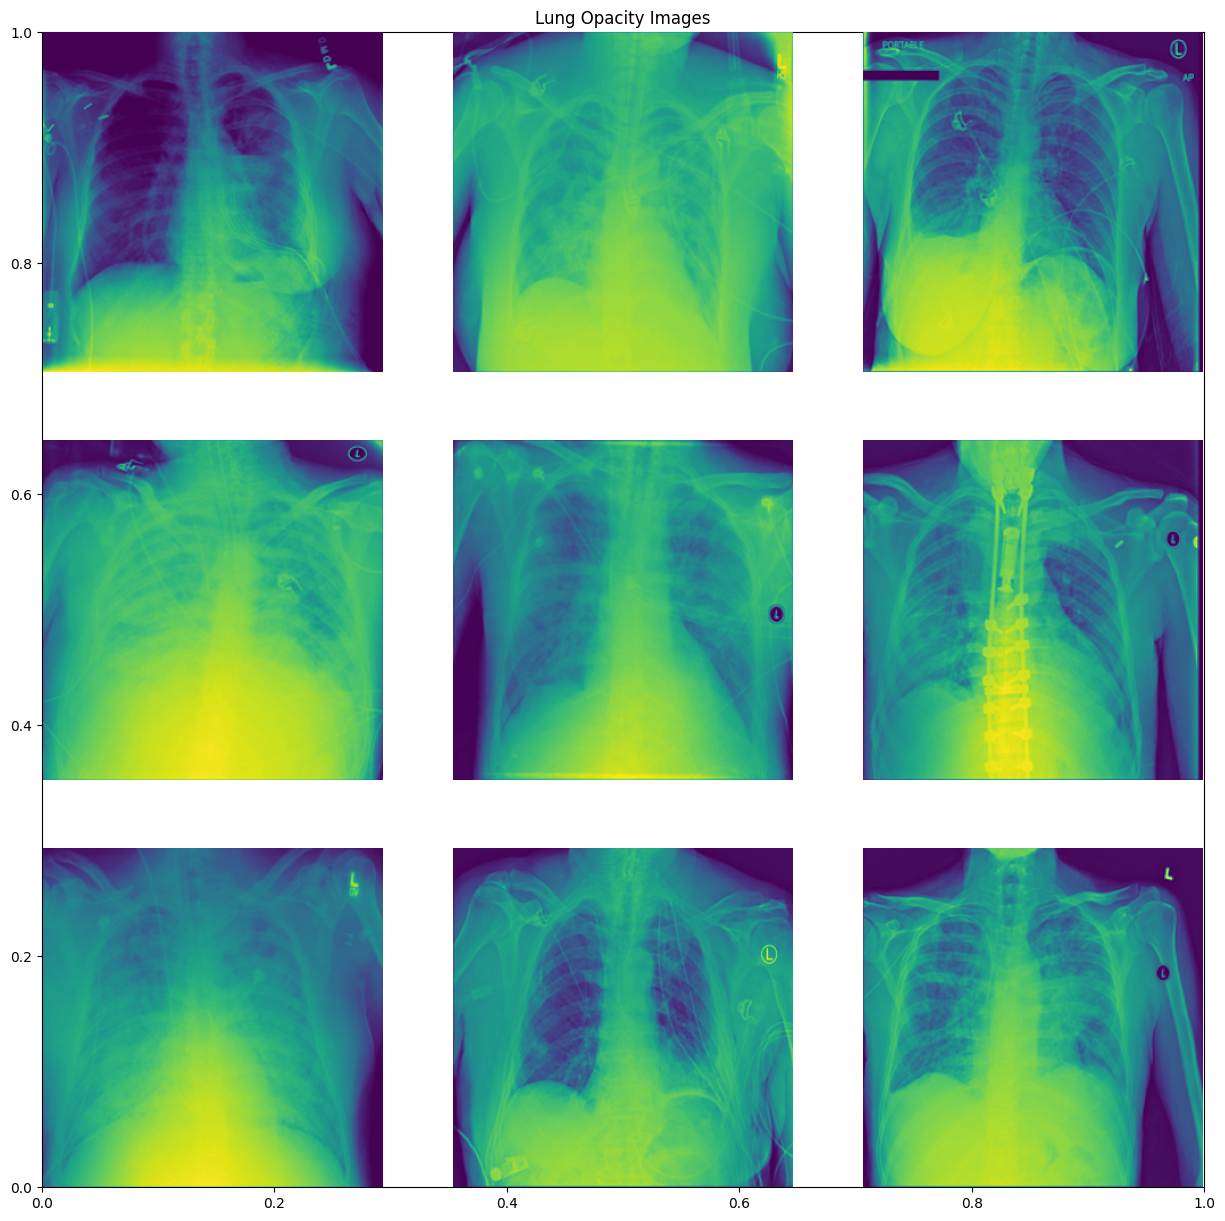

In [10]:
display_images('Lung Opacity Images', lung_opacity_imgs)

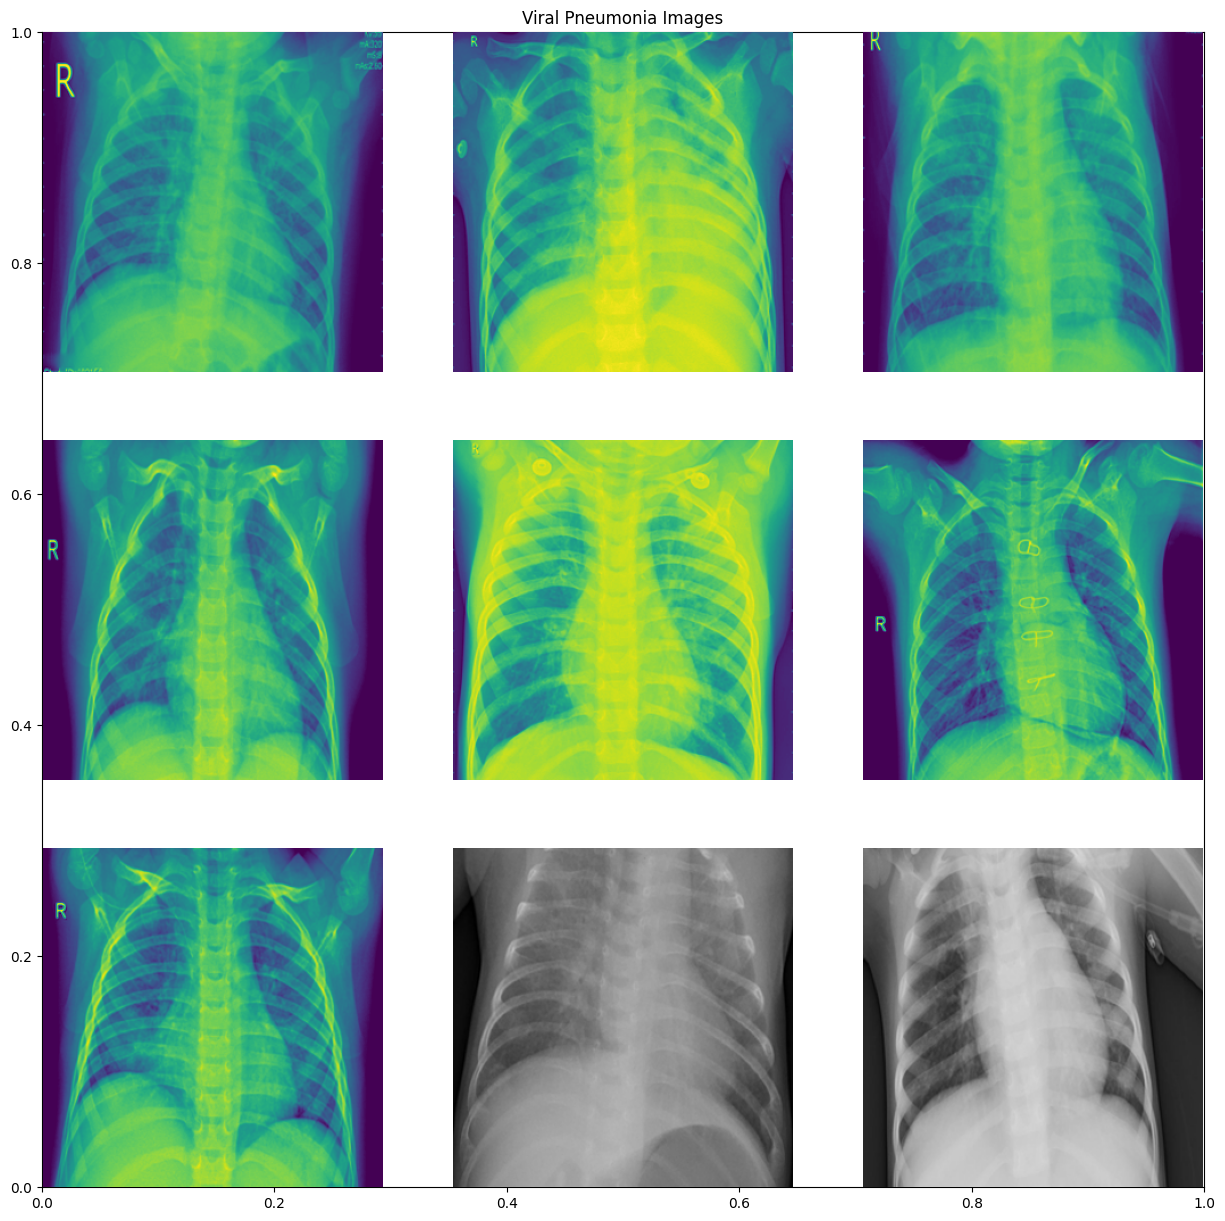

In [11]:
display_images('Viral Pneumonia Images', viral_pneummonia_imgs)

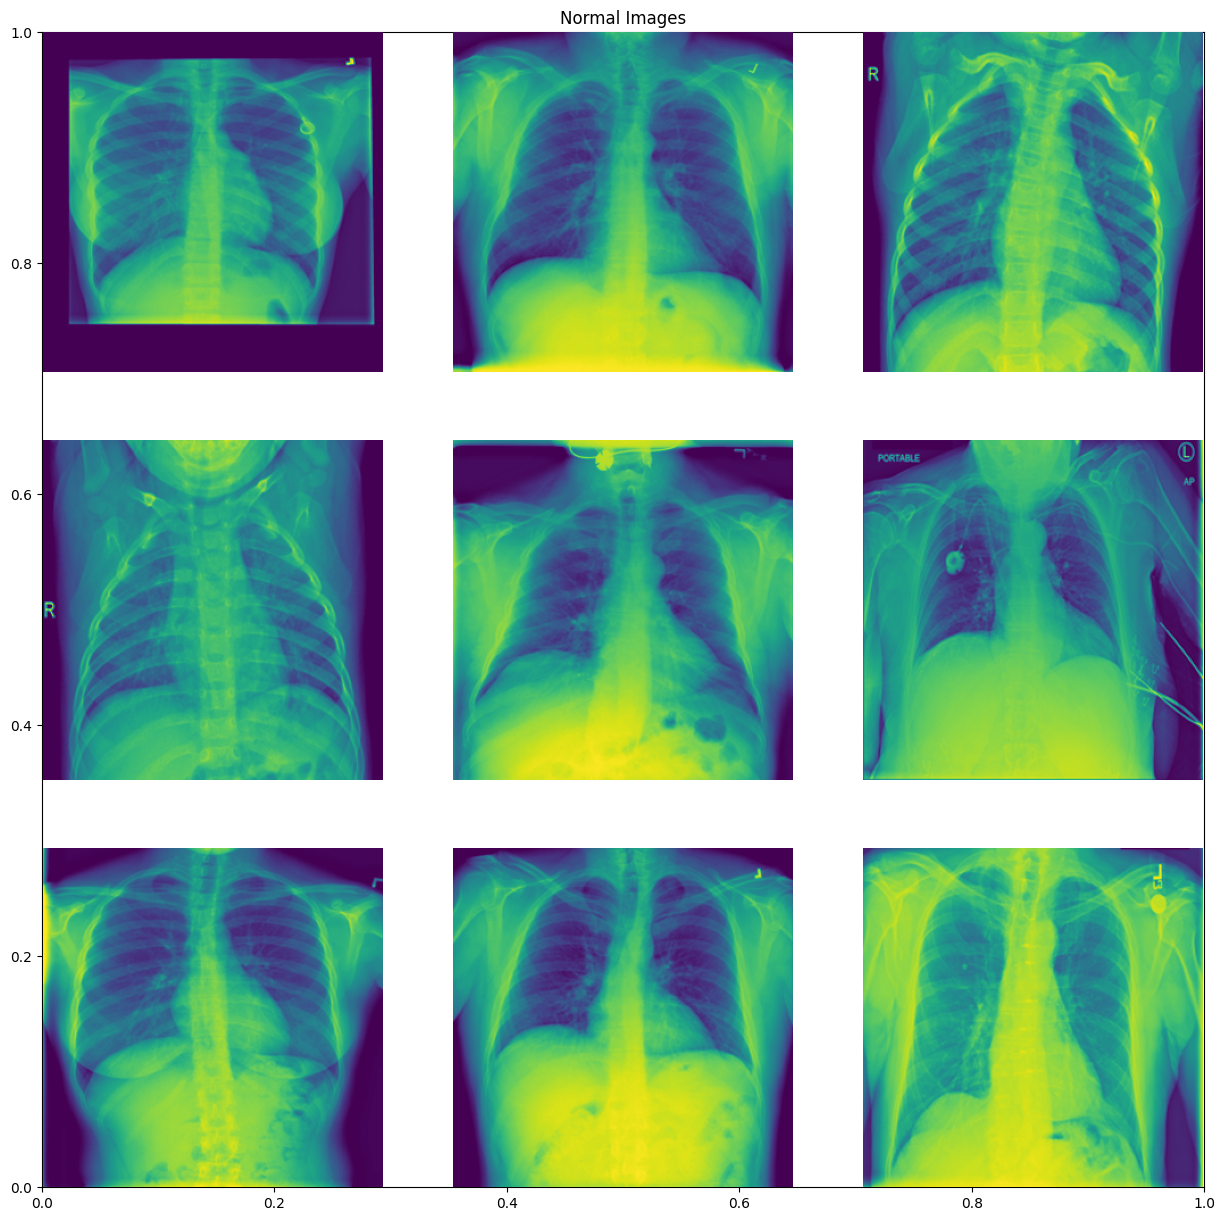

In [12]:
display_images('Normal Images', normal_imgs)

In [99]:
# Definir el tamaño del batch y el número límite de imágenes por batch
batch_size = 32

# Número límite de imágenes a procesar por batch
limit = 100  

input_shape = (64, 64, 3)

#Entrenamiento de los modelos
steps_per_epoch = limit // batch_size
validation_steps = limit // batch_size

# Data Augmentation y Preprocesamiento
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    os.path.join(path, "training"),
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical',  
    subset=None
)

validation_generator = datagen.flow_from_directory(
    os.path.join(path, "training"),
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical',
    subset=None
)

Found 16930 images belonging to 4 classes.
Found 16930 images belonging to 4 classes.


In [90]:
# Función para limitar el número de imágenes procesadas por batch
def limit_generator(generator, limit):
    while True:
        X_batch, y_batch = next(generator)
        limit = min(limit, X_batch.shape[0])  # Asegurarse de que el límite no sea mayor que el tamaño del batch
        indices = np.random.choice(X_batch.shape[0], limit, replace=False)
        yield (X_batch[indices], y_batch[indices])

train_generator = limit_generator(train_generator, limit)
validation_generator = limit_generator(validation_generator, limit)

In [100]:
# Modelo 1: CNN Personalizada
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 neuronas para 4 clases
])

In [101]:
# Modelo 2: Transfer Learning VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las primeras N capas (puedes experimentar con este número)
base_model.trainable = True  

for layer in base_model.layers[:15]:
    layer.trainable = False

model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [102]:
# Modelo 3: Transfer Learning ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las primeras N capas (puedes experimentar con este número)
base_model.trainable = True  

for layer in base_model.layers[:15]:
    layer.trainable = False

model3 = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [103]:
# Compilación de modelos
models = [model1, model2, model3]

for model in models:
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

In [104]:
# Entrenamiento con Early Stopping y ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True,
    mode='max',  # Dado que estamos monitoreando accuracy
    verbose=1  # Para mostrar mensajes cuando se guarda el modelo
)

In [105]:
for model in models:
    print("Modelo:", model.name)
    model.fit(
        train_generator,
        validation_data=validation_generator, 
        epochs=10,
        callbacks=[early_stopping, checkpoint]
    )

Modelo: sequential_21


C:\Users\marlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5610 - loss: 1.0873 - precision: 0.6897 - recall: 0.3037
Epoch 1: val_accuracy improved from -inf to 0.43792, saving model to best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 153s 282ms/step - accuracy: 0.5611 - loss: 1.0871 - precision: 0.6898 - recall: 0.3039 - val_accuracy: 0.4379 - val_loss: 1.1463 - val_precision: 0.5086 - val_recall: 0.2371
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6637 - loss: 0.8395 - precision: 0.7564 - recall: 0.5307
Epoch 2: val_accuracy improved from 0.43792 to 0.59929, saving model to best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 151s 286ms/step - accuracy: 0.6637 - loss: 0.8395 - precision: 0.7564 - recall: 0.5308 - val_accuracy: 0.5993 - val_loss: 0.9595 - val_precision: 0.6939 - val_recall: 0.4609
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7063 - loss: 0.7521 - precision: 0.7754 - recall: 0.5974
Epoch 3: val_accuracy improved from 0.59929 

In [109]:
# Evaluar modelos y graficar matriz de confusión
def evaluate_multiclass_model(model, validation_generator, steps):
    y_true = []
    y_pred = []

    # Obtener predicciones
    for _ in range(steps):
        X_batch, y_batch = next(validation_generator)
        predictions = model.predict(X_batch)
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sano', 'COVID', 'Opacidad', 'Neumonía Viral'], 
                yticklabels=['Sano', 'COVID', 'Opacidad', 'Neumonía Viral'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━

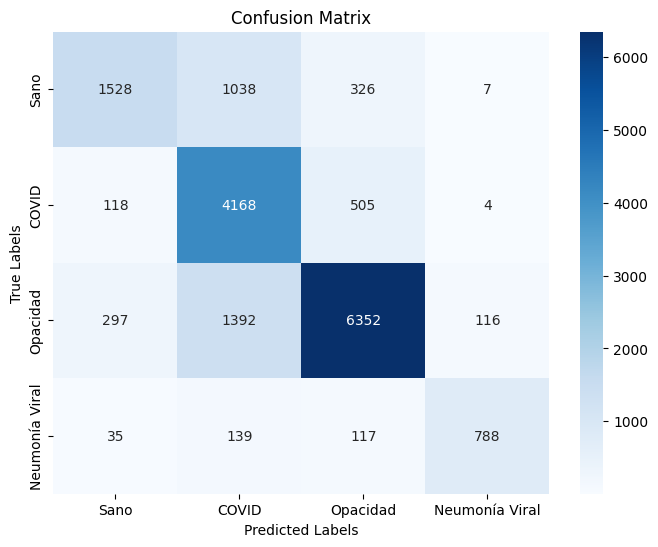

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

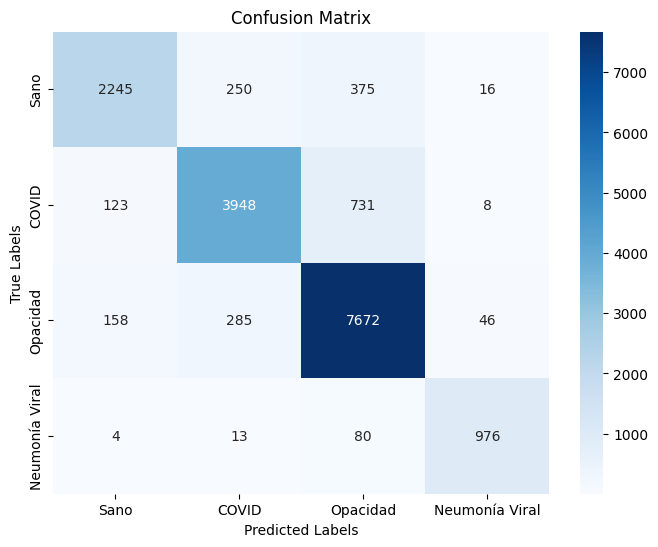

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

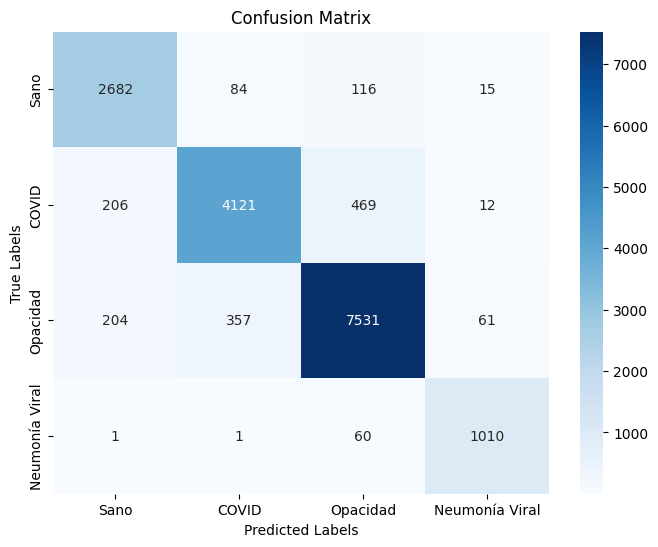

In [110]:
# Llamar a la función con cada modelo
y_true1, y_pred1 = evaluate_multiclass_model(model1, validation_generator, 530)
y_true2, y_pred2 = evaluate_multiclass_model(model2, validation_generator, 530)
y_true3, y_pred3 = evaluate_multiclass_model(model3, validation_generator, 530)

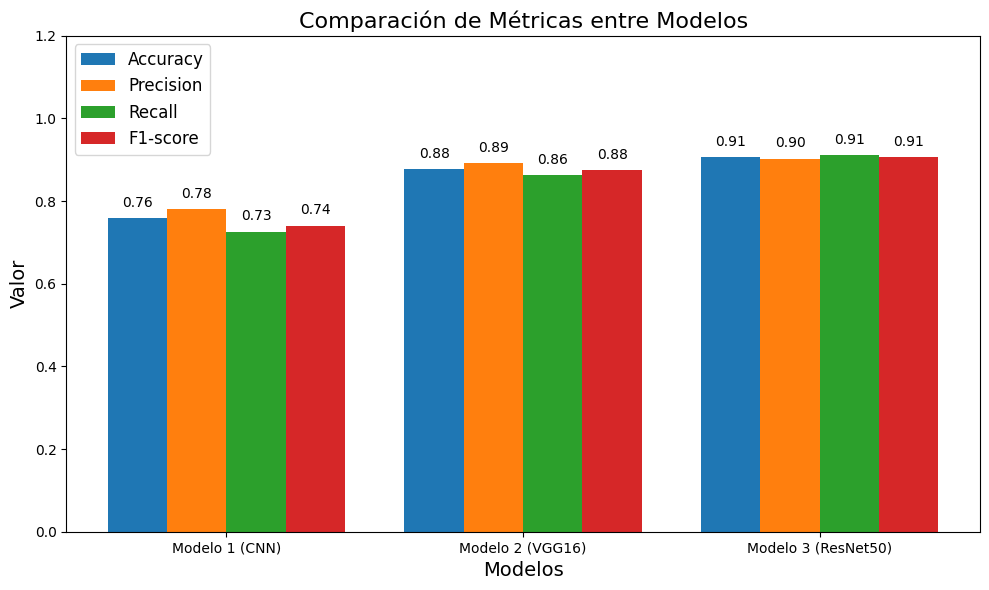

In [113]:
y_true_list = [y_true1, y_true2, y_true3]  # Verdaderos para cada modelo
y_pred_list = [y_pred1, y_pred2, y_pred3]  # Predicciones para cada modelo
model_names = ['Modelo 1 (CNN)', 'Modelo 2 (VGG16)', 'Modelo 3 (ResNet50)']

# Inicializar métricas
accuracy = []
precision = []
recall = []
f1_score = []

# Extraer métricas de cada modelo
for y_true, y_pred in zip(y_true_list, y_pred_list):
    report = classification_report(y_true, y_pred, output_dict=True, 
                                   target_names=['Sano', 'COVID', 'Opacidad', 'Neumonía Viral'])
    accuracy.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])
    recall.append(report['macro avg']['recall'])
    f1_score.append(report['macro avg']['f1-score'])

# Crear la matriz para las métricas
metrics = np.array([accuracy, precision, recall, f1_score])
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(model_names))  # Posiciones para las barras
width = 0.2  # Ancho de las barras

# Graficar cada métrica
for i in range(len(metric_names)):
    bars = ax.bar(x + i * width, metrics[i], width, label=metric_names[i])

    # Agregar etiquetas en las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Posición X centrada
            height + 0.02,                     # Posición Y (ligeramente encima de la barra)
            f'{height:.2f}',                   # Texto con 2 decimales
            ha='center', va='bottom', fontsize=10  # Alineación del texto
        )

# Configuración de la gráfica
ax.set_title('Comparación de Métricas entre Modelos', fontsize=16)
ax.set_xlabel('Modelos', fontsize=14)
ax.set_ylabel('Valor', fontsize=14)
ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(model_names)
ax.legend(loc='best', fontsize=12)
ax.set_ylim(0, 1.2)  # Ajustar el rango del eje Y (para métricas en [0, 1])

# Mostrar la gráfica
plt.tight_layout()
plt.show()